# Lab 3: Deep Sequence Modeling

The third lab session is about data that have a sequential structure that must be taken into account.

In [14]:
from __future__ import print_function
import tensorflow as tf
import os, json, re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline

# 3.1 Deal with sequential data
<img src="https://drive.google.com/uc?id=1k6HwtWlMTkVJFuyBpeBGF2sApqxR-KRc" width="600px" align="right"><br>
In this lab we see Deep Learning models that can process sequential data (text, timeseries,..).<br>
These models don’t take as input raw text: they only work with numeric tensors; **vectorizing** text is the process of transforming text into numeric tensors.<br><br><br>
The different units into which you can break down text (words, characters) are called tokens; then if you apply a tokenization scheme, you associate numeric vectors with the generated tokens.<br>
These vectors, packed into sequence tensors, are fed into Deep Neural Network.<br>
There are multiple ways to associate a vector with a token: we will see One-Hot Encoding and Token Embedding.<br>
In this section we are going to deal with:
* 3.1.1 One-Hot Encoding
* 3.1.2 Word embedding

## 3.1.1 One-Hot Encoding
One-Hot Encoding consists of associating a unique integer index with every word and then turning this integer index $i$ into a binary vector of size $N$ (the size of the vocabulary); the vector is all zeros except for the $i$-th entry, which is 1.
<img src="https://drive.google.com/uc?id=1OzK9t_WXQsaDuZoOTQSksLuNMubXm0gc" width="400px">

#### Try to perform One-Hot Encoding using Tokenizer
Keras provides the Tokenizer class for preparing text documents for DL.<br>
The Tokenizer must be constructed and then fit on either raw text documents or integer encoded text documents

In [2]:
# define 4 documents
docs = ['Well done!','Good work','Great effort','nice work']

# create the tokenizer
tokenizer = Tokenizer()

# fit the tokenizer on the documents
tokenizer.fit_on_texts(docs)


encoded_docs = tokenizer.texts_to_matrix(docs, mode='count') 
print(encoded_docs)

[[0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1.]]


Some problems related to this kind of encoding are sparsity of the solution and the high dimensionality of the vector encoding of the tokens.

## 3.1.2 Word embedding
<img src="https://drive.google.com/uc?id=1YRcQ1_5n8Qay0GFoSLVrNcEKWeik5G3S" width="400px" align="right"><br>
The vector obtained from word embedding is dense and has lower dimensionality w.r.t One-Hot Encoding vector; the dimensionality of embedding space vector is an hyperparameter.<br>
There are two ways to obtain word embeddings:<br>
* May be learned jointly with the network
* May use pre-trained word vectors (Word2Vec, GloVe,..)


Word embeddings maps human language into a geometric space; in a reasonable embedding space synonyms are embedded into similar word vectors and the geometric distance between any two word vectors reflects the semantic distance between the associated words (words meaning different things are embedded at points far away from each other, whereas related words are closer).<br>
How good is a word-embedding space depends on the specific task.<br>
It is reasonable to learn a new embedding space with every new task: with backpropagation and Keras it reduces to learn the weights of the Embedding layer.

### Learning Word Embeddings with the embedding layer
#### Load imdb dataset
This dataset contains movies reviews from IMDB, labeled by sentiment(positive/negative); reviews have been preprocessed, and each review is encoded as a sequence of word indexes(integers).<br>
https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification

In [3]:
max_features = 10000

imdb = tf.keras.datasets.imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)


#### Show the size of vocabulary and the most frequent words

In [4]:
word_to_index = imdb.get_word_index()

vocab_size = len(word_to_index)
print('Vocab size : ', vocab_size)


words_freq_list =words_freq_list = []
[]
for (k,v) in imdb.get_word_index().items():
    words_freq_list.append((k,v))

sorted_list = sorted(words_freq_list, key=lambda x: x[1])

print("50 most common words: \n")
print(sorted_list[0:50])

Vocab size :  88584
50 most common words: 

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('br', 7), ('in', 8), ('it', 9), ('i', 10), ('this', 11), ('that', 12), ('was', 13), ('as', 14), ('for', 15), ('with', 16), ('movie', 17), ('but', 18), ('film', 19), ('on', 20), ('not', 21), ('you', 22), ('are', 23), ('his', 24), ('have', 25), ('he', 26), ('be', 27), ('one', 28), ('all', 29), ('at', 30), ('by', 31), ('an', 32), ('they', 33), ('who', 34), ('so', 35), ('from', 36), ('like', 37), ('her', 38), ('or', 39), ('just', 40), ('about', 41), ("it's", 42), ('out', 43), ('has', 44), ('if', 45), ('some', 46), ('there', 47), ('what', 48), ('good', 49), ('more', 50)]


In [5]:
word_to_index['otherwise']

897

#### Converting IMDB dataset to readable reviews

Reviews in the IMDB dataset have been encoded as a sequence of integers. The dataset also contains an index for converting the reviews back into human readable form.

In [7]:
# Get the word index from the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

word_index = {k:v for k,v in word_index.items()}

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


#### Data Insight

In [7]:
# Map for readable classnames
class_names = ["Negative", "Positive"]

# Concatonate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[3]))
print("  Review Sentiment: " + str(y_train[3]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[3]))
print("  Review Sentiment: " + class_names[y_train[3]])

Maximum review length: 2494
Minimum review length: 7
Mean review length: 234.75892

Machine readable Review
  Review Text: [1, 4, 2, 2, 33, 2804, 4, 2040, 432, 111, 153, 103, 4, 1494, 13, 70, 131, 67, 11, 61, 2, 744, 35, 3715, 761, 61, 5766, 452, 9214, 4, 985, 7, 2, 59, 166, 4, 105, 216, 1239, 41, 1797, 9, 15, 7, 35, 744, 2413, 31, 8, 4, 687, 23, 4, 2, 7339, 6, 3693, 42, 38, 39, 121, 59, 456, 10, 10, 7, 265, 12, 575, 111, 153, 159, 59, 16, 1447, 21, 25, 586, 482, 39, 4, 96, 59, 716, 12, 4, 172, 65, 9, 579, 11, 6004, 4, 1615, 5, 2, 7, 5168, 17, 13, 7064, 12, 19, 6, 464, 31, 314, 11, 2, 6, 719, 605, 11, 8, 202, 27, 310, 4, 3772, 3501, 8, 2722, 58, 10, 10, 537, 2116, 180, 40, 14, 413, 173, 7, 263, 112, 37, 152, 377, 4, 537, 263, 846, 579, 178, 54, 75, 71, 476, 36, 413, 263, 2504, 182, 5, 17, 75, 2306, 922, 36, 279, 131, 2895, 17, 2867, 42, 17, 35, 921, 2, 192, 5, 1219, 3890, 19, 2, 217, 4122, 1710, 537, 2, 1236, 5, 736, 10, 10, 61, 403, 9, 2, 40, 61, 4494, 5, 27, 4494, 159, 90, 263, 2311,

#### Pre-processing Data
We need to make sure that our reviews are of a uniform length.
Some reviews will need to be truncated, while others need to be padded.

In [8]:
maxlen = 50
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print("Shape Training  Data: " + str(x_train.shape))
print("Shape Training Output Data: " + str(y_train.shape))
print("Shape Test Data: " + str(x_test.shape))
print("Shape Test Output Data: " + str(y_test.shape))

Shape Training  Data: (25000, 50)
Shape Training Output Data: (25000,)
Shape Test Data: (25000, 50)
Shape Test Output Data: (25000,)


# 3.2 Recurrent Neural Network
Here https://colah.github.io/posts/2015-08-Understanding-LSTMs/ you can find a clear explanation about RNNs and LSTMs; the following is a summary of the main concepts.


A major characteristic of some neural networks, as ConvNet, is that they have no memory: each input is processed independently, with no state kept in between inputs. Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in.<br>
A recurrent neural network (RNN) adopts the same principle but in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far.

<img src="https://drive.google.com/uc?id=1RaDXXygc0HJv6YyIAjU4_Nbw1bXzAhAJ" width="650px"><br>




Each input $x_{i=t-1, t, t+1, ..}$ is combined with the internal state and then is applied an activation function (e.g. $tanh$); then the output is computed $h_{i=t-1, t, t+1, ..}$ and the internal state is updated.<br>
In many cases, you just need the last output ($h_{i=last t}$ at the end of the loop), because it already contains information
about the entire sequence.
<img src="https://drive.google.com/uc?id=1RtulDLKQnzZTSbBsD2n7TIlRVEaESB8o" width="550px">


#### Create the model
In the following sections we will develop different models. Be careful to the fact that we are dealing with a binary classification problem!

In [13]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, 16))
model.add(tf.keras.layers.Dropout(rate=0.2 )) # Randomly disable 20% of neurons
# Complete the model, it should be made by at least:
# 1 SimpleRNN layer
# 1 Dense layer
# model.add(tf.keras.layers.SimpleRNN(32,dropout=0.2,recurrent_dropout=0.2))#20% dropout for input units and 20% dropout for recurrent connections.
model.add(tf.keras.layers.SimpleRNN(32,dropout=0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

#### Train the model

In [14]:
# Train your model here
history = model.fit(x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 8s 51ms/step - loss: 0.6357 - acc: 0.6240 - val_loss: 0.5254 - val_acc: 0.7582
Epoch 2/10
157/157 [==============================] - 8s 49ms/step - loss: 0.4560 - acc: 0.7934 - val_loss: 0.9515 - val_acc: 0.6598
Epoch 3/10
157/157 [==============================] - 8s 49ms/step - loss: 0.3831 - acc: 0.8339 - val_loss: 0.4237 - val_acc: 0.8060
Epoch 4/10
157/157 [==============================] - 8s 53ms/step - loss: 0.3394 - acc: 0.8586 - val_loss: 0.4489 - val_acc: 0.7808
Epoch 5/10
157/157 [==============================] - 8s 50ms/step - loss: 0.3095 - acc: 0.8720 - val_loss: 0.4260 - val_acc: 0.8116
Epoch 6/10
157/157 [==============================] - 8s 49ms/step - loss: 0.2858 - acc: 0.8827 - val_loss: 0.4551 - val_acc: 0.7974
Epoch 7/10
157/157 [==============================] - 8s 51ms/step - loss: 0.2669 - acc: 0.8936 - val_loss: 0.4559 - val_acc: 0.8098
Epoch 8/10
157/157 [==============================] - 8s 51ms/step - 

In [18]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

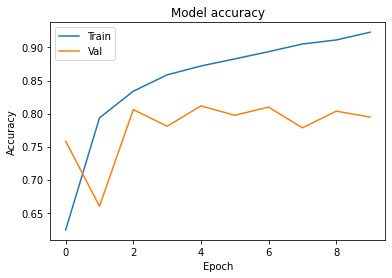

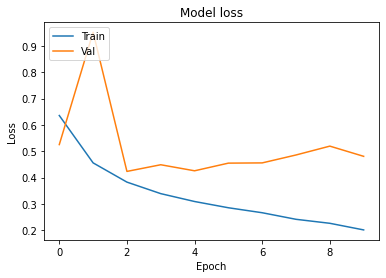

In [16]:
plot_history(history)

#### Evaluate the model

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

# Classification Report
predicted_classes = model.predict_classes(x_test)
print(classification_report(y_test, predicted_classes, target_names=class_names))

782/782 [==============================] - 4s 5ms/step - loss: 0.4842 - acc: 0.7948
Test accuracy: 0.795, Test loss: 0.484
              precision    recall  f1-score   support

    Negative       0.79      0.80      0.80     12500
    Positive       0.80      0.79      0.79     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



#### Try to build a new model where you stack several recurrent layers.
In such a setup, you have to get all of the intermediate layers to return full sequence of outputs. This is needed to return batch size, timesteps, hidden state. By doing this the output should contain all historical generated outputs along with time stamps (3D). This way the next layer can work further on the data.

In [19]:
# Build the model. It should be made by at least:
# 1 Embedding layer
# More than 1 SimpleRNN layer, do not forget to put the return_sequences parameter to True 
# 1 Dense layer
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, 16))
model.add(tf.keras.layers.Dropout(rate=0.2 )) # Randomly disable 20% of neurons
model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True,dropout=0.2))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True,dropout=0.2))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True,dropout=0.2))
model.add(tf.keras.layers.SimpleRNN(32,recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

#### Train the model

In [20]:
# Train your model here
history = model.fit(x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 28s 181ms/step - loss: 0.7035 - acc: 0.5038 - val_loss: 0.6936 - val_acc: 0.5042
Epoch 2/10
157/157 [==============================] - 28s 175ms/step - loss: 0.6956 - acc: 0.5067 - val_loss: 0.6934 - val_acc: 0.4970
Epoch 3/10
157/157 [==============================] - 28s 179ms/step - loss: 0.6536 - acc: 0.5857 - val_loss: 0.5689 - val_acc: 0.7062
Epoch 4/10
157/157 [==============================] - 28s 178ms/step - loss: 0.4869 - acc: 0.7674 - val_loss: 0.4355 - val_acc: 0.7956
Epoch 5/10
157/157 [==============================] - 27s 169ms/step - loss: 0.4114 - acc: 0.8184 - val_loss: 0.5069 - val_acc: 0.7230
Epoch 6/10
157/157 [==============================] - 27s 172ms/step - loss: 0.3660 - acc: 0.8453 - val_loss: 0.4242 - val_acc: 0.8040
Epoch 7/10
157/157 [==============================] - 27s 170ms/step - loss: 0.3284 - acc: 0.8634 - val_loss: 0.4126 - val_acc: 0.8106
Epoch 8/10
157/157 [==============================] - 2

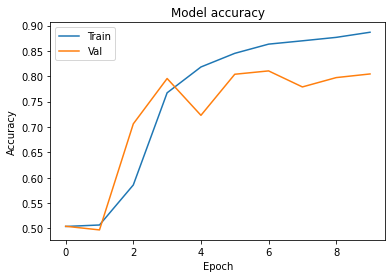

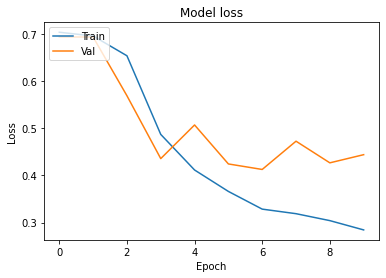

In [21]:
plot_history(history)

#### Evaluate the model

In [22]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

predicted_classes = model.predict_classes(x_test)
print(classification_report(y_test, predicted_classes, target_names=class_names))

782/782 [==============================] - 12s 15ms/step - loss: 0.4384 - acc: 0.8110
Test accuracy: 0.811, Test loss: 0.438
              precision    recall  f1-score   support

    Negative       0.83      0.78      0.80     12500
    Positive       0.79      0.84      0.82     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



**What can you say about the obtained results? What about the comparison between these results and the ones obtained in the single layer RNN?**

# 3.3 LSTM Network
LSTMs are a special kind of recurrent neural network which works, for many tasks, much better than the standard RNNs.<br>
These nets are capable of learning long-term dependencies (they are explicitly designed to avoid the long-term dependency problem); remembering information for long periods of time is practically their default behavior.<br><br>

<img src="https://drive.google.com/uc?id=1CQ0RkQrnIkr1dFqSU1qHfPh5sJe_A6pQ" width="650px"><br>

RNNs have a very simple structure, such as a single $tanh$ layer.<br>
LSTMs also have a chain like structure, but the repeating module has a different structure: instead of having a single neural network layer, there are four, interacting in a very special way

#### Create LSTM model in TensorFlow

In [23]:
# Build the model. It should be made by at least:
# 1 Embedding layer
# 1 LSTM layer
# 1 Dense layer
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_features, output_dim=32))
model.add(tf.keras.layers.Dropout(rate=0.2 ))
model.add(tf.keras.layers.LSTM(32,dropout=0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

#### Train the model

In [24]:
# Train your model here
history = model.fit(x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 2s 12ms/step - loss: 0.5529 - acc: 0.7096 - val_loss: 0.4400 - val_acc: 0.7924
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 0.3879 - acc: 0.8255 - val_loss: 0.4502 - val_acc: 0.7864
Epoch 3/10
157/157 [==============================] - 1s 9ms/step - loss: 0.3335 - acc: 0.8609 - val_loss: 0.4007 - val_acc: 0.8166
Epoch 4/10
157/157 [==============================] - 1s 8ms/step - loss: 0.3061 - acc: 0.8715 - val_loss: 0.4200 - val_acc: 0.8122
Epoch 5/10
157/157 [==============================] - 1s 8ms/step - loss: 0.2835 - acc: 0.8828 - val_loss: 0.4083 - val_acc: 0.8140
Epoch 6/10
157/157 [==============================] - 1s 8ms/step - loss: 0.2671 - acc: 0.8887 - val_loss: 0.4097 - val_acc: 0.8094
Epoch 7/10
157/157 [==============================] - 1s 8ms/step - loss: 0.2549 - acc: 0.8943 - val_loss: 0.5158 - val_acc: 0.8006
Epoch 8/10
157/157 [==============================] - 1s 8ms/step - loss: 0

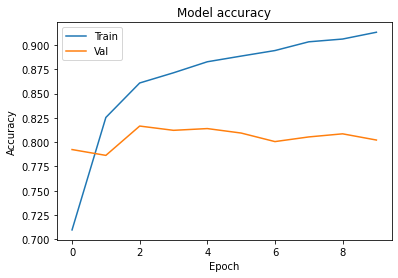

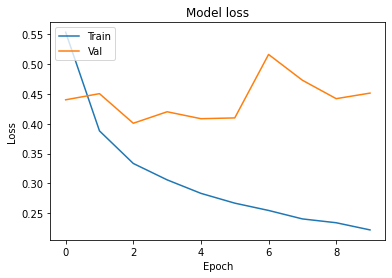

In [25]:
plot_history(history)

#### Evaluate the model

In [26]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

predicted_classes = model.predict_classes(x_test)
print(classification_report(y_test, predicted_classes, target_names=class_names))

782/782 [==============================] - 2s 3ms/step - loss: 0.4563 - acc: 0.8007
Test accuracy: 0.801, Test loss: 0.456
              precision    recall  f1-score   support

    Negative       0.76      0.87      0.81     12500
    Positive       0.85      0.73      0.79     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



# 3.4 Reuters newswire classification dataset

The reuters newswire classification dataset is a dataset of 11,228 newswires from Reuters, labeled over 46 topics. More information about the dataset and how to use it can be found here:
https://keras.io/api/datasets/reuters/

Try to build a new model dealing with this new dataset.
Try to use both the RNN and the LSTM approach, and select the best of them. What do you expect will be the best? Be carefull that this domain shift will imply some changes in your code as it is not a binary classification problem anymore!

#### Load Reuters dataset

In [5]:
max_features = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=max_features)

2113536/2110848 [==============================] - 0s 0us/step


#### Data Insight

In [8]:
class_names=['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

num_classes = np.max(y_train) + 1
print('Number of Training Samples: {}'.format(len(x_train)))
print('Number of Test Samples: {}'.format(len(x_test)))
print('Number of classes: ', np.max(y_train)+1)        # plus one because indexing of categories starts at 0


# Concatonate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[3]))
print("  Review Sentiment: " + str(y_train[3]))


# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[3]))
print("  Review Sentiment: " + class_names[y_train[3]])

Number of Training Samples: 8982
Number of Test Samples: 2246
Number of classes:  46
Maximum review length: 2376
Minimum review length: 2
Mean review length: 145.96419665122906

Machine readable Review
  Review Text: [1, 4, 686, 867, 558, 4, 37, 38, 309, 2276, 465, 893, 3541, 114, 2902, 69, 312, 35, 15, 7, 335, 1679, 21, 25, 3675, 2, 3498, 58, 69, 68, 493, 5, 25, 465, 377, 2430, 4, 293, 1172, 739, 4379, 8, 7, 1510, 1131, 13, 899, 6, 4, 990, 309, 415, 4519, 6920, 645, 3916, 791, 5, 4379, 75, 8, 24, 10, 1311, 4677, 5, 344, 756, 7, 2, 231, 9691, 2603, 1413, 43, 509, 43, 68, 327, 5, 2, 3498, 297, 638, 73, 430, 22, 4, 580, 7, 48, 41, 30, 2, 136, 4, 344, 298, 4, 580, 40, 344, 5078, 2, 291, 1488, 10, 3148, 5, 231, 6250, 1308, 5, 8250, 7043, 21, 2, 1622, 990, 309, 415, 265, 5992, 8945, 1149, 9118, 2, 4, 344, 9691, 756, 3729, 2, 4667, 2, 3249, 28, 10, 2190, 24, 77, 41, 682, 10, 4851, 2048, 7, 4, 5540, 2926, 1598, 22, 370, 5954, 7541, 5, 54, 5232, 1685, 2916, 10, 1571, 946, 60, 51, 3249, 5249, 4

In [10]:
maxlen =50
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

#### RNN

#### Create model

In [11]:
# Build the model.

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, 16))
model.add(tf.keras.layers.Dropout(rate=0.2 ))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True,dropout=0.2))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True,dropout=0.2))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True,dropout=0.2))
model.add(tf.keras.layers.SimpleRNN(32,dropout=0.2))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
y_train_cat = tf.keras.utils.to_categorical(y_train)

#### Train the model

In [16]:

# Train your model here
history = model.fit(x_train, y_train_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.15)

Epoch 1/10
120/120 [==============================] - 6s 49ms/step - loss: 1.4807 - acc: 0.6182 - val_loss: 1.8695 - val_acc: 0.5334
Epoch 2/10
120/120 [==============================] - 6s 49ms/step - loss: 1.4378 - acc: 0.6323 - val_loss: 1.9666 - val_acc: 0.5030
Epoch 3/10
120/120 [==============================] - 6s 49ms/step - loss: 1.3791 - acc: 0.6489 - val_loss: 1.9892 - val_acc: 0.5037
Epoch 4/10
120/120 [==============================] - 6s 50ms/step - loss: 1.3490 - acc: 0.6540 - val_loss: 1.9737 - val_acc: 0.5178
Epoch 5/10
120/120 [==============================] - 6s 50ms/step - loss: 1.3074 - acc: 0.6609 - val_loss: 1.9766 - val_acc: 0.5230
Epoch 6/10
120/120 [==============================] - 6s 50ms/step - loss: 1.2529 - acc: 0.6800 - val_loss: 2.0906 - val_acc: 0.5171
Epoch 7/10
120/120 [==============================] - 6s 50ms/step - loss: 1.2189 - acc: 0.6833 - val_loss: 2.3270 - val_acc: 0.4622
Epoch 8/10
120/120 [==============================] - 6s 49ms/step - 

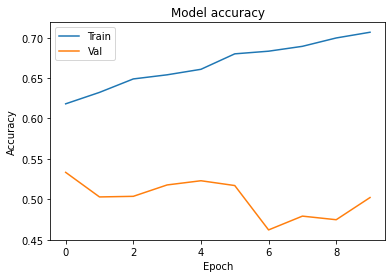

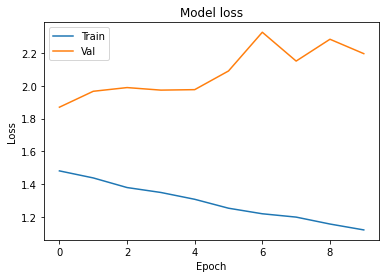

In [19]:
plot_history(history)

#### Evaluate the model

In [20]:
y_test_cat = tf.keras.utils.to_categorical(y_test)

test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

rounded_y_test=np.argmax(y_test_cat, axis=1)

predicted_classes = model.predict_classes(x_test)
print(confusion_matrix(rounded_y_test, predicted_classes))
print(classification_report(rounded_y_test, predicted_classes,target_names=class_names))


71/71 [==============================] - 1s 9ms/step - loss: 2.1591 - acc: 0.5040
Test accuracy: 0.504, Test loss: 2.159
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[ 0  1  0 ...  0  0  0]
 [ 0 40  2 ...  0  0  0]
 [ 0  2  3 ...  0  0  0]
 ...
 [ 0  1  1 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]]
                 precision    recall  f1-score   support

          cocoa       0.00      0.00      0.00        12
          grain       0.20      0.38      0.26       105
        veg-oil       0.06      0.15      0.09        20
           earn       0.78      0.88      0.83       813
            acq       0.64      0.56      0.60       474
          wheat       0.00      0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### LSTM

#### Create model

In [21]:
# Build the model.

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, 16))
model.add(tf.keras.layers.Dropout(rate=0.2 ))
model.add(tf.keras.layers.LSTM(32, return_sequences=True,dropout=0.2))
model.add(tf.keras.layers.LSTM(32, return_sequences=True,dropout=0.2))
model.add(tf.keras.layers.LSTM(32, return_sequences=True,dropout=0.2))
model.add(tf.keras.layers.LSTM(32,dropout=0.2))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
y_train = tf.keras.utils.to_categorical(y_train)

#### Train the model

In [22]:
# Train your model here
history = model.fit(x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.15)

Epoch 1/10
120/120 [==============================] - 13s 109ms/step - loss: 2.4310 - acc: 0.3767 - val_loss: 1.9973 - val_acc: 0.4384
Epoch 2/10
120/120 [==============================] - 12s 102ms/step - loss: 1.8812 - acc: 0.4959 - val_loss: 2.1201 - val_acc: 0.4102
Epoch 3/10
120/120 [==============================] - 12s 101ms/step - loss: 1.7495 - acc: 0.5215 - val_loss: 2.0480 - val_acc: 0.4622
Epoch 4/10
120/120 [==============================] - 12s 102ms/step - loss: 1.6909 - acc: 0.5347 - val_loss: 1.8212 - val_acc: 0.5082
Epoch 5/10
120/120 [==============================] - 12s 102ms/step - loss: 1.6390 - acc: 0.5413 - val_loss: 1.8355 - val_acc: 0.4889
Epoch 6/10
120/120 [==============================] - 12s 103ms/step - loss: 1.6084 - acc: 0.5494 - val_loss: 1.7791 - val_acc: 0.5163
Epoch 7/10
120/120 [==============================] - 12s 102ms/step - loss: 1.5737 - acc: 0.5626 - val_loss: 1.7906 - val_acc: 0.5185
Epoch 8/10
120/120 [==============================] - 1

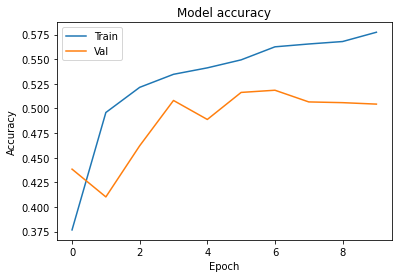

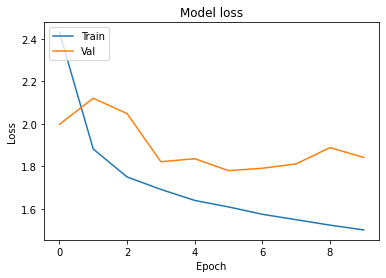

In [23]:
plot_history(history)

#### Evaluate the model

In [24]:
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

rounded_y_test=np.argmax(y_test_cat, axis=1)

predicted_classes = model.predict_classes(x_test)
print(confusion_matrix(rounded_y_test, predicted_classes))
print(classification_report(rounded_y_test, predicted_classes,target_names=class_names))



71/71 [==============================] - 1s 18ms/step - loss: 1.8592 - acc: 0.4907
Test accuracy: 0.491, Test loss: 1.859
[[0 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
                 precision    recall  f1-score   support

          cocoa       0.00      0.00      0.00        12
          grain       0.09      0.04      0.05       105
        veg-oil       0.00      0.00      0.00        20
           earn       0.95      0.79      0.86       813
            acq       0.67      0.68      0.67       474
          wheat       0.00      0.00      0.00         5
         copper       0.00      0.00      0.00        14
        housing       0.00      0.00      0.00         3
   money-supply       0.00      0.00      0.00        38
         coffee       0.00      0.00      0.00        25
          sugar       0.08      0.20      0.11        30
          trade       0.10      0.29      0.14        83
       reserves 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
#warning
print("not predicted classes: ", set(y_test) - set(predicted_classes))
#This means that there is no F-score to calculate for this label, and thus the F-score for this case is considered to be 0.0. 

not predicted classes:  {0, 2, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}


**Are the results accordant to what you expected? Can you notice some differences between the RNN and the LSTM results? Why?**